In [4]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [5]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree
 

def readGraph(filePath):
    graph = nx.Graph()
    edges = []
    
    with open(filePath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: continue
            
            # Preskoči meta-podatke (p edge 11 55)
            if parts[0] in ['p', 'c', 'edge']:
                continue
            
            # Čitaj ivice
            try:
                if len(parts) >= 2:
                    # Uzimamo prva dva broja u redu, šta god da su
                    u, v = int(parts[-2]), int(parts[-1])
                    edges.append((u, v))
            except ValueError:
                continue

    # Ključni momenat: NetworkX automatski kreira čvorove na osnovu ivica
    graph.add_edges_from(edges)
    
    # Ispisujemo tačan broj učitanih ivica radi tvoje provere
    # Ako ovde ne piše 55 za K11, fajl ti ne valja!
    return graph

def getFitness(chromosome, edges, maxNode):
    # node_slots: za svaki čvor čuvamo listu boja njegovih ivica
    node_slots = [[] for _ in range(maxNode + 1)]
    
    for i, (u, v) in enumerate(edges):
        color = chromosome[i]
        node_slots[u].append(color)
        node_slots[v].append(color)

    total_conflicts = 0
    for colors in node_slots:
        if len(colors) < 2:
            continue
            
        colors.sort()
        
        current_count = 1
        for j in range(1, len(colors)):
            if colors[j] == colors[j-1]:
                current_count += 1
            else:
                if current_count > 1:
                    total_conflicts += (current_count * (current_count - 1)) // 2
                current_count = 1
        if current_count > 1:
            total_conflicts += (current_count * (current_count - 1)) // 2
            
    return total_conflicts

In [6]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = popSize - rank
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]


In [7]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]


In [8]:
def mutationSmart(chromosome, edges, maxNode, numColors):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    
    # Prolazimo kroz sve ivice da nađemo susedne (optimizaćemo ovo kasnije)
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
            
    # Koristimo isključivo DOZVOLJENI opseg boja (numColors)
    available = list(set(range(1, numColors + 1)) - forbidden)
    
    if available:
        chromosome[idx] = random.choice(available)
    else:
        # Ako nema slobodne boje u dozvoljenom opsegu, 
        # uzmi bilo koju iz DOZVOLJENOG opsega, ne dodaj nove!
        chromosome[idx] = random.randint(1, numColors) 
    return chromosome


def mutationRandom(chromosome, edges, maxNode,numColors):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, numColors)
    return chromosome

#def mutationSwap(chromosome, edges, maxNode, delta):
#    idx1, idx2 = random.sample(range(len(chromosome)), 2)
#    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
#    return chromosome
#KAO NIJE KORISNO ZA MINIMUM EDGE COLORING


def mutationConflict(chromosome, edges, maxNode, numColors):
    # 1. Mapiramo koji čvor ima koje boje na svojim ivicama
    # Ovo nam pomaže da brzo vidimo gde su duplikati boja
    node_colors = {i: [] for i in range(1, maxNode + 1)}
    for i, (u, v) in enumerate(edges):
        node_colors[u].append(chromosome[i])
        node_colors[v].append(chromosome[i])
        
    # 2. Pronalazimo indekse svih ivica koje učestvuju u konfliktu
    conflicted_indices = []
    for i, (u, v) in enumerate(edges):
        # Ako se trenutna boja ivice pojavljuje više od jednom kod čvora u ili v
        if node_colors[u].count(chromosome[i]) > 1 or node_colors[v].count(chromosome[i]) > 1:
            conflicted_indices.append(i)
            
    # 3. Akcija:
    if not conflicted_indices:
        # Ako nema konflikata (čestitamo!), uradi malu nasumičnu promenu
        idx = random.randrange(len(chromosome))
        chromosome[idx] = random.randint(1, numColors)
    else:
        # Izaberi jednu od ivica koje STVARNO prave problem i promeni joj boju
        idx = random.choice(conflicted_indices)
        chromosome[idx] = random.randint(1, numColors)
    
    return chromosome



In [9]:
def normEdge(u, v):
    return (u, v) if u < v else (v, u)

In [10]:
def confIndices(solution, edges, edgesIndex, neighbourhood):
    conflictingIndices = []
    for i, edge in enumerate(edges):
        # Proveravamo komšije preko unapred spremljene liste
        for nei_edge in neighbourhood[edge]:
            idx = edgesIndex[nei_edge]
            if solution[idx] == solution[i]:
                conflictingIndices.append(i)
                break 
    return conflictingIndices

In [11]:
def getNeighbours(graph, edges):
    neighbourhood = {normEdge(u, v): [] for _, (u, v) in enumerate(graph.edges())} 


    for edge in edges:
        u, v = edge
        uNei = list(graph.neighbors(u))
        vNei = list(graph.neighbors(v))
        uNei.remove(v)
        vNei.remove(u)
        mapa = {}

        for i in    uNei:
            nei = normEdge(u, i)
            neighbourhood[edge].append(nei)
            mapa[nei] = True

        for i in vNei:
            nei = normEdge(v, i)
            if nei not in mapa:
              neighbourhood[edge].append(nei)

    return neighbourhood

In [12]:
def recalcConflicts(edges, edgesIndex, oldConf, solution, neighbourhood, oldColour, newColour, i):
    num = 0

    edge = edges[i]
    myNeighbours = neighbourhood[edge]

    for nei in myNeighbours:
        idx = edgesIndex[nei]
        if solution[idx] == oldColour:
            num -= 1
        if solution[idx] == newColour:
            num += 1
    
    return oldConf + num


In [13]:
def localSearchRepair(code, edges, neighbourhood, maxColor, maxSteps, edgesIndex,maxNode):
    for _ in range(maxSteps):

        #fitness = getFitness(code, edges, 0)
        #max_n = max(max(u, v) for u, v in edges)
        fitness = getFitness(code, edges, maxNode)#trenutni fitnes

        if fitness == 0:
            break

        # confEdges = []
        # for i in range(len(code)):
        #     for nei in neighbourhood[i]:
        #         if code[i] == code[nei]:
        #             confEdges.append(i)
        #             break
        confEdges = confIndices(code, edges, edgesIndex, neighbourhood)
        
        if not confEdges:
            break
            # return code

        # e = random.choice(confEdges)#indeks ivice
        # oldColor = code[e]


        # for color in range(1,maxColor+1):
        #     if color == oldColor:
        #         continue

        #     code[e] = color
        #     newFitness = recalcConflicts(edges, edgesIndex, fitness, code, neighbourhood, oldColor, color, e)

        #     if newFitness < fitness:
        #         fitness = newFitness
        #         break
        #         # return code
        #     else:
        #         code[e] = oldColor
        edgeIdx = random.choice(confEdges)
        u, v = edges[edgeIdx]
        
        # Skupljamo boje susednih ivica da nađemo slobodnu
        forbidden = set()
        for nei_edge in neighbourhood[edges[edgeIdx]]:
            forbidden.add(code[edgesIndex[nei_edge]])
            
        available = [c for c in range(1, maxColor + 1) if c not in forbidden]
        if available:
            code[edgeIdx] = random.choice(available)
        else:
            code[edgeIdx] = random.randint(1, maxColor)

    return code

In [14]:
def localSearchRepairHARD(code, edges, neighbourhood, maxColor, maxSteps, edgesIndex,maxNode):
    for _ in range(maxSteps):

        #fitness = getFitness(code, edges, 0)
        #max_n = max(max(u, v) for u, v in edges)
        fitness = getFitness(code, edges, maxNode)#trenutni fitnes

        if fitness == 0:
            break

        # confEdges = []
        # for i in range(len(code)):
        #     for nei in neighbourhood[i]:
        #         if code[i] == code[nei]:
        #             confEdges.append(i)
        #             break
        confEdges = confIndices(code, edges, edgesIndex, neighbourhood)
        
        if not confEdges:
            break
            # return code

        # e = random.choice(confEdges)#indeks ivice
        # oldColor = code[e]


        # for color in range(1,maxColor+1):
        #     if color == oldColor:
        #         continue

        #     code[e] = color
        #     newFitness = recalcConflicts(edges, edgesIndex, fitness, code, neighbourhood, oldColor, color, e)

        #     if newFitness < fitness:
        #         fitness = newFitness
        #         break
        #         # return code
        #     else:
        #         code[e] = oldColor
        edgeIdx = random.choice(confEdges)
        u, v = edges[edgeIdx]
        
        # Skupljamo boje susednih ivica da nađemo slobodnu
        forbidden = set()
        for nei_edge in neighbourhood[edges[edgeIdx]]:
            forbidden.add(code[edgesIndex[nei_edge]])
            
        available = [c for c in range(1, maxColor + 1) if c not in forbidden]
        if available:
            code[edgeIdx] = random.choice(available)
        else:
            bestColor = code[edgeIdx]
            minConf = float('inf')
            
            for c in range(1, maxColor + 1):
                # Izbroj koliko susednih ivica ima ovu boju
                conflicts = sum(1 for nei_edge in neighbourhood[edges[edgeIdx]] 
                              if code[edgesIndex[nei_edge]] == c)
                
                if conflicts < minConf:
                    minConf = conflicts
                    bestColor = c
            
            code[edgeIdx] = bestColor

    return code

In [15]:
def calcConflicts(edges, edgesIndex, solution, neighbourhood):
    num  = 0
    
    for i in range(len(edges)):
        edge = edges[i]
        myNeighbours = neighbourhood[edge]

        for nei in myNeighbours:
            idx = edgesIndex[nei]
            if solution[idx] == solution[i]:
                num += 1
        
    return (num // 2)

In [16]:
from time import perf_counter

In [130]:
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc, numColours):
    #edges = list(graph.edges())
    edges = [normEdge(u, v) for (u,v) in graph.edges()]
    if not edges: return [], 0, []
    edgesIndex = {edge : i for i, edge in enumerate(edges)}
    neighbourhood = getNeighbours(graph, edges)
    startTime = perf_counter()
    
    # maxNode nam treba za mutationConflict da zna veličinu rečnika čvorova
    maxNode = max(graph.nodes())
    numEdges = len(edges)
    
    # Inicijalizacija: Sada strogo poštujemo numColours
    population = [[random.randint(1, numColours) for _ in range(numEdges)] for _ in range(popSize)]
    
    history = []
    
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        # fitnesses = [calcConflicts(edges, edgesIndex, c, neighbourhood) for c in population]
        bestFit = min(fitnesses)
        print(gen,bestFit,flush=True)#ispisuje gen i fitnes
        history.append(bestFit)

        if bestFit == 0:
            print(f'NASAO {selFunc.__name__} {crossFunc.__name__} {mutFunc.__name__}',flush=True)
        
        
        if bestFit == 0:
            # Popunjavamo istoriju do kraja radi grafikona
            history.extend([0] * (maxIters - len(history)))
            break

        #Max time 100s 
        if perf_counter() - startTime > 480:
            history.extend([0] * (maxIters - len(history)))
            break
            
        # Elitizam: Sortiramo i uzimamo 2 najbolja
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]]
        
        while len(newPop) < popSize:
            # 1. Poboljšanje: Izbegavamo da p1 i p2 budu ista jedinka (ako je moguće)
            p1_idx = population.index(selFunc(population, fitnesses))
            p2_idx = population.index(selFunc(population, fitnesses))
            
            # Ako je populacija raznolika, probaj da nađeš različite roditelje
            attempts = 0
            while p1_idx == p2_idx and attempts < 5:
                p2_idx = population.index(selFunc(population, fitnesses))
                attempts += 1
            
            p1, p2 = population[p1_idx], population[p2_idx]
            
            #2. Ukrštanje
            child = crossFunc(p1, p2)
            
            # 3. Mutacija (povećana šansa jer koristimo pametne mutacije)
            # Za Edge Coloring, 0.3 - 0.4 je odličan ratio
            mutationProb = 0.1
            if random.random() < mutationProb:
                # mutationConflict i mutationSmart sada dobijaju sve što im treba
                child = mutFunc(child, edges, maxNode, numColours)
                
            if gen >= 100:
                child = localSearchRepairHARD(child, edges, neighbourhood, numColours, 100, edgesIndex,maxNode)

            newPop.append(child)
            # 1. Ukrštanje - dobijamo dvoje dece
            # child1, child2 = crossFunc(p1, p2)

            # for c in [child1, child2]:
            #     if len(newPop) < popSize:
            #  # 2. Mutacija - samo u 35% slučajeva (da ne kvarimo previše)
            #         if random.random() < 0.35:
            #             c = mutFunc(c, edges, maxNode, numColours)
        
            # # 3. Local Search - uvek popravlja dete ako smo u kasnijoj fazi
            #         if gen >= 600:
            #             c = localSearchRepair(c, edges, neighbourhood, numColours, 10, edgesIndex, maxNode)
        
            #         newPop.append(c)

            
        population = deepcopy(newPop)
        
    # Finalna provera najboljeg
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    
    return population[bestIdx], finalFits[bestIdx], history

In [131]:
def processAndVisualize(filePath):
    graph = readGraph(filePath)

    # >>> OVDE DODAJ OVE LINIJE <<<
    print(f"\n" + "="*40)
    print(f"DEBUG ZA FAJL: {os.path.basename(filePath)}")
    print(f"Stvarni broj čvorova: {graph.number_of_nodes()}")
    print(f"Stvarni broj ivica: {graph.number_of_edges()}")
    # >>> KRAJ DODATKA <<<

    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)

    # Dodaj i ovo da proverimo šta je funkcija izračunala za Deltu
    print(f"Izračunata Delta: {delta}")
    print("="*40 + "\n")

    if graph.number_of_edges() == 0: return

    
    f_lower = fileName.lower()
    type_info = "Unknown Graph Type"
    theory_note = ""
    is_bipartite = nx.is_bipartite(graph)
    if "completegraph" in f_lower or "k_" in f_lower:
        try:
            n = int(''.join(filter(str.isdigit, fileName)))
            type_info = f"Complete Graph K({n})"
            if n % 2 == 0: theory_note = f"Class 1 (Expected χ' = Δ = {n-1})"
            else: theory_note = f"Class 2 (Expected χ' = Δ + 1 = {n})"
        except: type_info = "Complete Graph"
    elif "bipartite" in f_lower or is_bipartite:
        type_info = "Bipartite Graph"
        theory_note = f"Always Class 1 (Expected χ' = Δ = {delta})"
    elif "petersen" in f_lower or "snark" in f_lower or "flower" in f_lower:
        type_info = "SNARK / Petersen Graph"
        theory_note = f"Class 2 (Expected χ' = Δ + 1 = {delta+1})"
    elif "regular" in f_lower:
        type_info = f"Random Regular Graph (d={delta})"
        theory_note = "Most are Class 1"
    elif "graph" in f_lower:
        type_info = "Random G(n,p) Graph"
        theory_note = "Vizing's Theorem: Class 1 or 2"

    print(f"\n>>> ANALYZING: {fileName}")
    print(f"[TYPE]: {type_info}")
    if theory_note: print(f"[THEORY]: {theory_note}")

    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverUniform, crossoverSinglePoint, crossoverTwoPoint]
    mutations = [mutationSmart, mutationRandom, mutationConflict]

    
    def run_tests(num_cols):
        res_list = []
        for sel in selections:
            for cross in crossovers:
                for mut in mutations:
                    sName = sel.__name__.replace('selection', '')
                    cName = cross.__name__.replace('crossover', '')
                    mName = mut.__name__.replace('mutation', '')
                    t0 = time.perf_counter()
                    sol, fit, hist = runGaModular(graph, 1200, 50, sel, cross, mut, num_cols)
                    dt = time.perf_counter() - t0
                    res_list.append({'selection': sName, 'crossover': cName, 'mutation': mName,
                                     'fit': fit, 'time': dt, 'hist': hist, 'sol': sol, 'cols': num_cols})
        return res_list

    # Prvi krug
    allResults = run_tests(delta)
    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    found_zero = allResults[0]['fit'] == 0
    secondAttemptResults = []

    if not found_zero:
        print(f"!!! Nema nule sa {delta} boja. Pokrećem Delta + 1 = {delta+1}...")
        secondAttemptResults = run_tests(delta + 1)
        secondAttemptResults.sort(key=lambda x: (x['fit'], x['time']))

    
    def prepare_table(results):
        data = []
        for i, r in enumerate(results):
            data.append([i, r['selection'], r['crossover'], r['mutation'], r['fit'], r['cols'], f"{r['time']:.6f}"])
        return data

    headers = ["Rank", "selection", "crossover", "mutation", "num of conf", "colours", "time"]
    
    # Konzola: Top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(prepare_table(allResults if found_zero else secondAttemptResults)[:3], headers=headers, tablefmt="fancy_grid"))

    # Fajl: format sa dopisivanjem rezultata
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph: {fileName} | Type: {type_info}\nTheory: {theory_note}\nMax Degree (Delta): {delta}\n\n")
        f.write("--- RESULTS FOR DELTA ---\n")
        f.write(tabulate(prepare_table(allResults), headers=headers, tablefmt="fancy_grid"))
        if secondAttemptResults:
            f.write("\n\n--- RESULTS FOR DELTA + 1 ---\n")
            f.write(tabulate(prepare_table(secondAttemptResults), headers=headers, tablefmt="fancy_grid"))
        
        if found_zero: f.write(f"\n\nRESULT: Class 1 found (Index = {delta})")
        elif secondAttemptResults and secondAttemptResults[0]['fit'] == 0: f.write(f"\n\nRESULT: Class 2 found (Index = {delta+1})")
        else: f.write(f"\n\nRESULT: GA failed to find 0 conflicts.")

    
    best = allResults[0] if found_zero or not secondAttemptResults else secondAttemptResults[0]
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    #nx.draw(graph, pos, edge_color=best['sol'], width=2.5, with_labels=True, node_color='lightblue', edge_cmap=plt.cm.rainbow)
    edges_list = list(graph.edges())
    nx.draw(graph, pos, 
        edgelist=edges_list,        # Eksplicitno kažemo koje ivice crtamo
        edge_color=best['sol'],     # Boje iz pobedničkog hromozoma
        width=3.0,                  # Malo deblje ivice da se bolje vidi boja
        with_labels=True, 
        node_color='lightblue', 
        node_size=500,
        edge_cmap=plt.cm.rainbow)   # Mapira brojeve 1, 2, 3... u dugu
        #edge_vmin=1,                # Najmanja moguća boja
        #edge_vmax=num_cols)         # Najveća moguća boja (numColours)
    plt.title(f"Winner (Rank 0):\n{best['selection']} + {best['crossover']} + {best['mutation']}")

    plt.subplot(1, 2, 2)
    plot_data = allResults[:3] if found_zero else secondAttemptResults[:3]
    for i, res in enumerate(plot_data):
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.8)
    plt.tight_layout()
    plt.show()
    plt.close('all')
    print(f"Full table saved to: {txtPath}")


DEBUG ZA FAJL: completeBipartite10.txt
Stvarni broj čvorova: 20
Stvarni broj ivica: 100
Izračunata Delta: 10


>>> ANALYZING: completeBipartite10.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 10)
Top 3 Combinations for completeBipartite10.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Random     │             0 │        10 │ 4.15354 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Random     │             0 │        10 │ 6.06006 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ Uniform     │ Conflict   │             0 │        10 │ 6.24575 │
╘════════

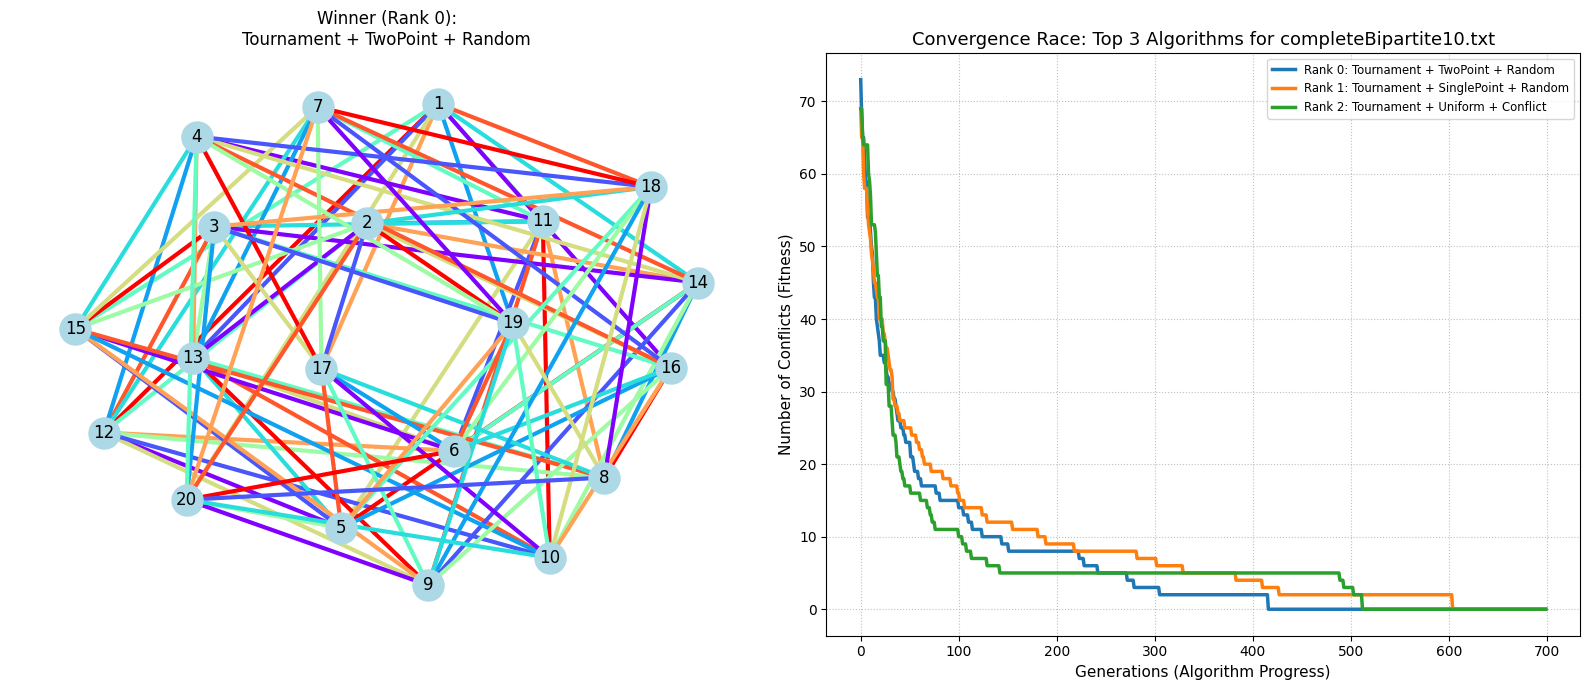

Full table saved to: resultsGA/completeBipartite10.txt


In [108]:

filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeBipartite10.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: completeBipartite20.txt
Stvarni broj čvorova: 40
Stvarni broj ivica: 400
Izračunata Delta: 20


>>> ANALYZING: completeBipartite20.txt
[TYPE]: Bipartite Graph
[THEORY]: Always Class 1 (Expected χ' = Δ = 20)
Top 3 Combinations for completeBipartite20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ TwoPoint    │ Smart      │             0 │        20 │ 219.761 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ Uniform     │ Conflict   │             2 │        20 │ 363.069 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Random     │             2 │        20 │ 364.269 │
╘════════

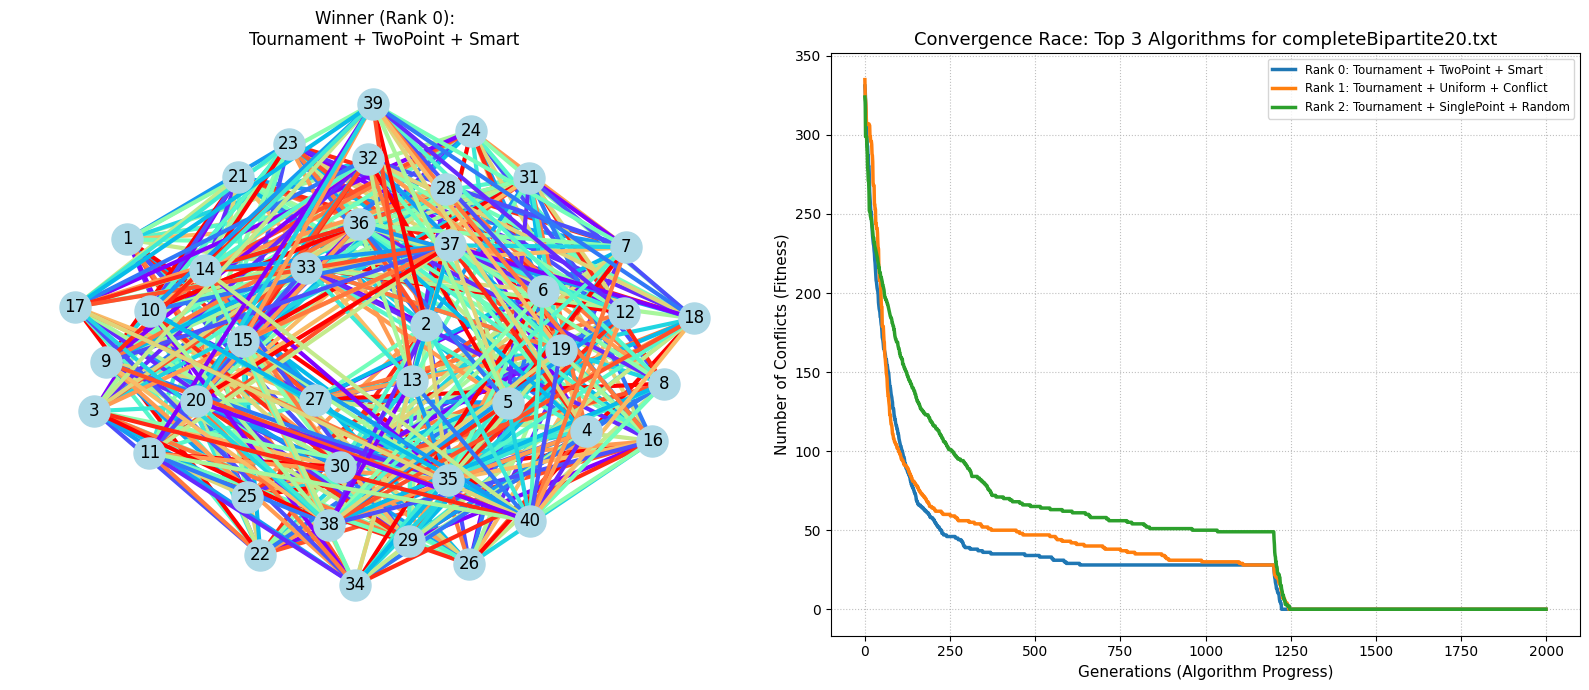

Full table saved to: resultsGA/completeBipartite20.txt


In [37]:
#KASNIJE
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeBipartite20.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: completeGraph20.txt
Stvarni broj čvorova: 20
Stvarni broj ivica: 190
Izračunata Delta: 19


>>> ANALYZING: completeGraph20.txt
[TYPE]: Complete Graph K(20)
[THEORY]: Class 1 (Expected χ' = Δ = 19)
Top 3 Combinations for completeGraph20.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │        19 │ 20.5566 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ TwoPoint    │ Conflict   │             0 │        19 │ 24.2828 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Random     │             0 │        19 │ 32.1202 │
╘════════╧═════════════

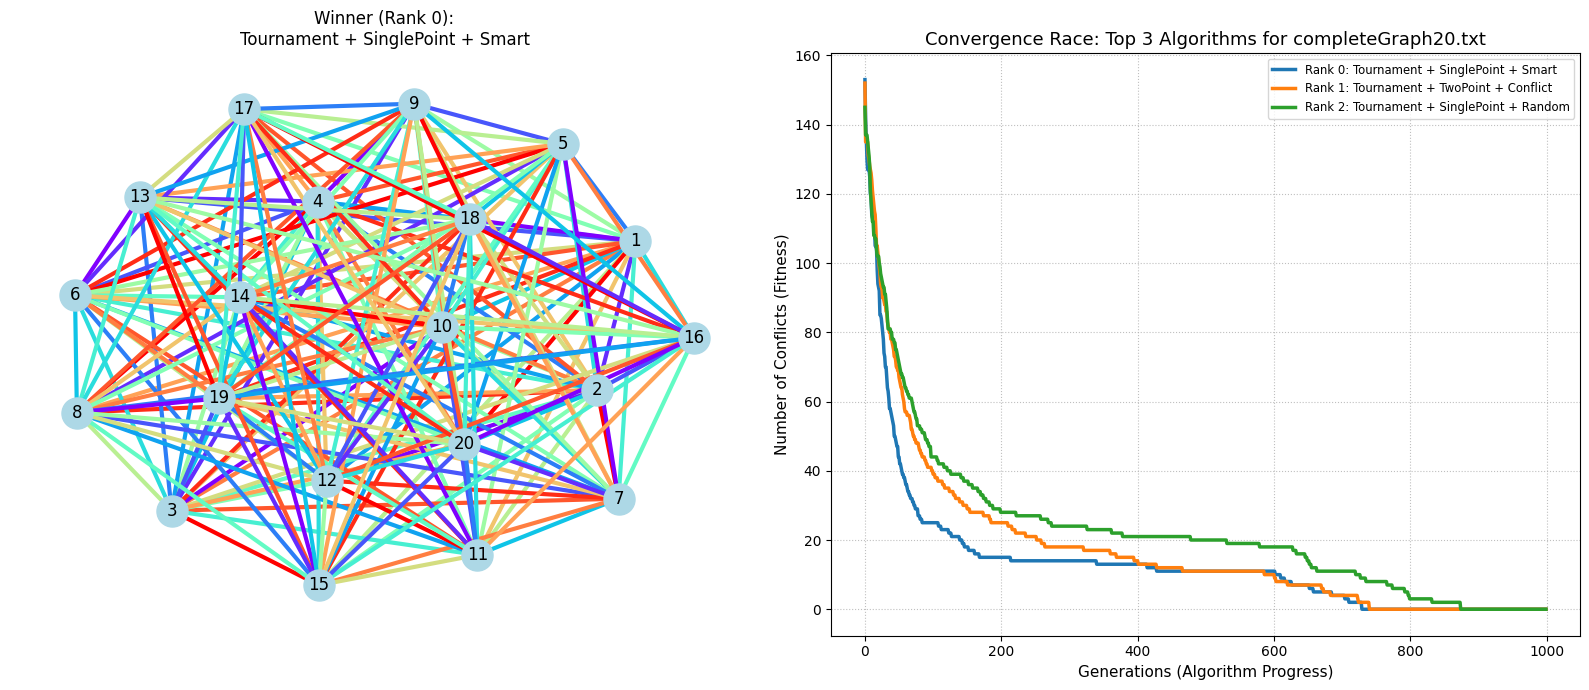

Full table saved to: resultsGA/completeGraph20.txt


In [118]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/completeGraph20.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: gcol.txt
Stvarni broj čvorova: 100
Stvarni broj ivica: 2487
Izračunata Delta: 61


>>> ANALYZING: gcol.txt
[TYPE]: Unknown Graph Type
Top 3 Combinations for gcol.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │             0 │        61 │ 451.456 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │            34 │        61 │ 483.897 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │            83 │        61 │ 486.363 │
╘════════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════════╛


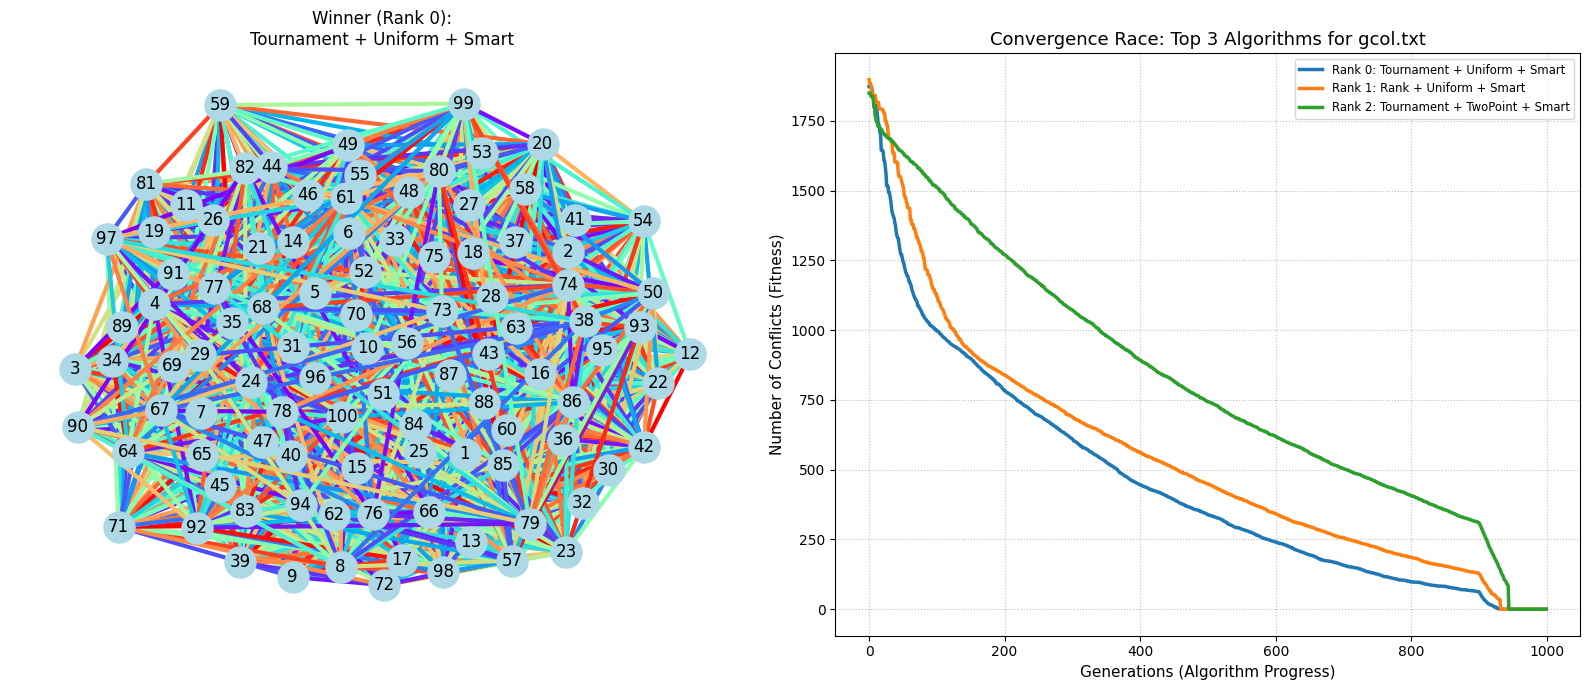

Full table saved to: resultsGA/gcol.txt


In [81]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/gcol.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: graph40_0.8.txt
Stvarni broj čvorova: 40
Stvarni broj ivica: 607
Izračunata Delta: 35


>>> ANALYZING: graph40_0.8.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph40_0.8.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Conflict   │             0 │        35 │ 49.8217 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ TwoPoint    │ Conflict   │             0 │        35 │ 82.1803 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Conflict   │             0 │        35 │ 83.3807 │
╘════════╧═════════════╧════════════

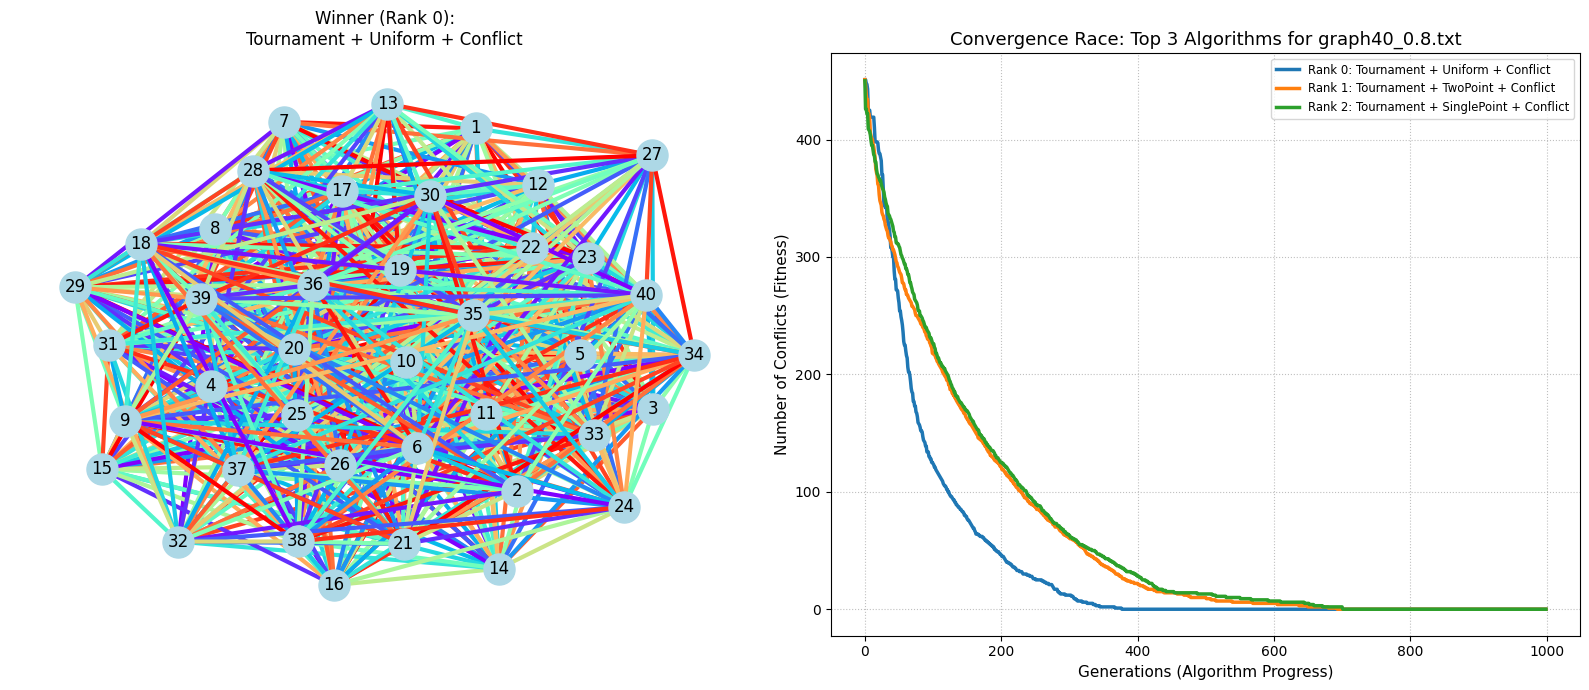

Full table saved to: resultsGA/graph40_0.8.txt


In [136]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph40_0.8.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: graph50_0.5.txt
Stvarni broj čvorova: 50
Stvarni broj ivica: 639
Izračunata Delta: 32


>>> ANALYZING: graph50_0.5.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph50_0.5.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Conflict   │             0 │        32 │ 36.066  │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │        32 │ 38.1059 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Rank        │ Uniform     │ Conflict   │             0 │        32 │ 45.4057 │
╘════════╧═════════════╧════════════

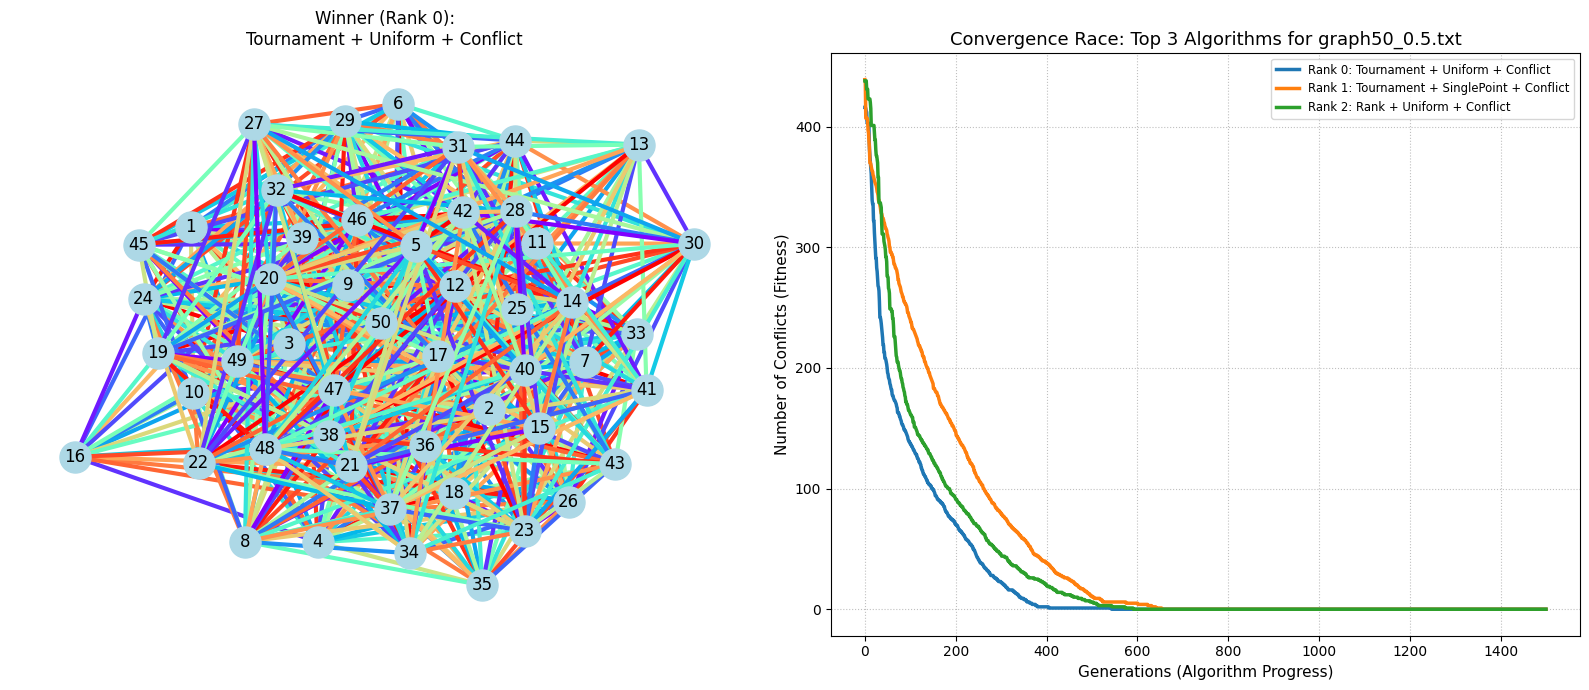

Full table saved to: resultsGA/graph50_0.5.txt


In [148]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph50_0.5.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: graph85_0.6.txt
Stvarni broj čvorova: 85
Stvarni broj ivica: 2129
Izračunata Delta: 62


>>> ANALYZING: graph85_0.6.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for graph85_0.6.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ Uniform     │ Smart      │             0 │        62 │ 287.542 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Rank        │ Uniform     │ Smart      │             9 │        62 │ 304.736 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ TwoPoint    │ Smart      │            41 │        62 │ 305.098 │
╘════════╧═════════════╧═══════════

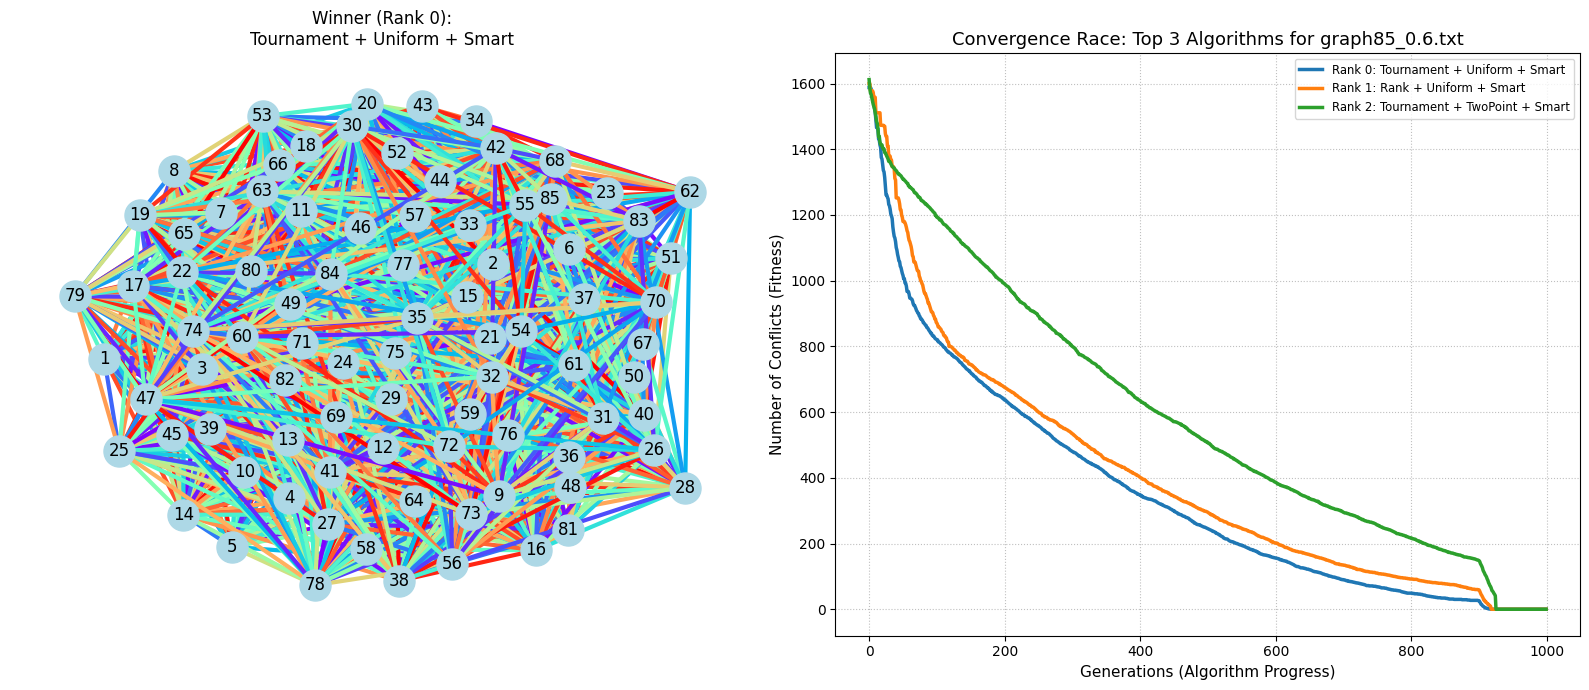

Full table saved to: resultsGA/graph85_0.6.txt


In [70]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/graph85_0.6.txt"
processAndVisualize(filename)#kasnije


DEBUG ZA FAJL: randomGraph5_50.txt
Stvarni broj čvorova: 50
Stvarni broj ivica: 125
Izračunata Delta: 5


>>> ANALYZING: randomGraph5_50.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph5_50.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         5 │ 11.1717 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │         5 │ 17.1267 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Tournament  │ SinglePoint │ Random     │             2 │         5 │ 30.1896 │
╘════════╧═════════════╧═

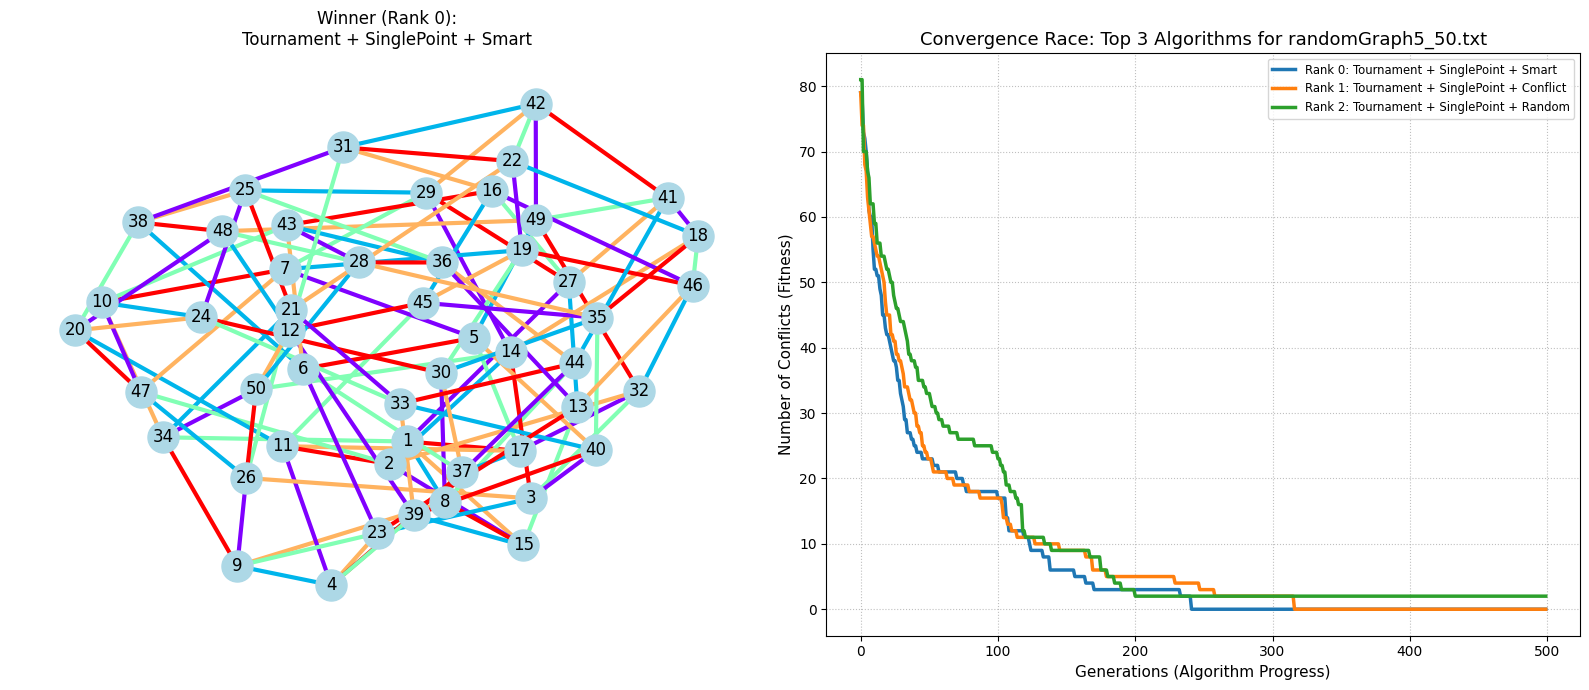

Full table saved to: resultsGA/randomGraph5_50.txt


In [154]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph5_50.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: randomGraph6_30.txt
Stvarni broj čvorova: 30
Stvarni broj ivica: 90
Izračunata Delta: 6


>>> ANALYZING: randomGraph6_30.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
Top 3 Combinations for randomGraph6_30.txt:
╒════════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│   Rank │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│      0 │ Tournament  │ SinglePoint │ Smart      │             0 │         6 │ 3.14665 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      1 │ Tournament  │ SinglePoint │ Conflict   │             0 │         6 │ 4.05247 │
├────────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│      2 │ Roulette    │ TwoPoint    │ Conflict   │             0 │         6 │ 7.49668 │
╘════════╧═════════════╧══

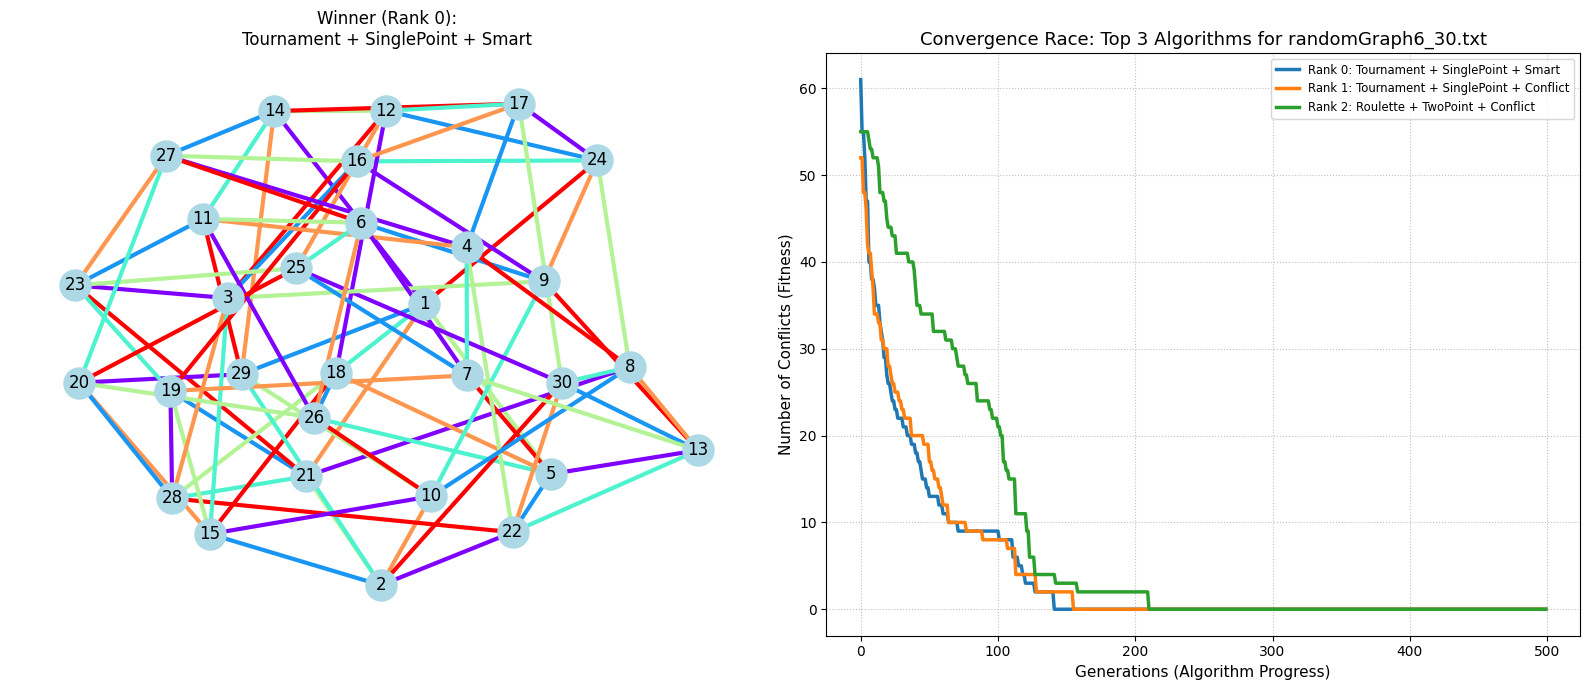

Full table saved to: resultsGA/randomGraph6_30.txt


In [155]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph6_30.txt"
processAndVisualize(filename)

In [132]:
filename = "/home/user/minimumEdgeColoring/tests/experimentalTests/randomGraph6_90.txt"
processAndVisualize(filename)


DEBUG ZA FAJL: randomGraph6_90.txt
Stvarni broj čvorova: 90
Stvarni broj ivica: 270
Izračunata Delta: 6


>>> ANALYZING: randomGraph6_90.txt
[TYPE]: Random G(n,p) Graph
[THEORY]: Vizing's Theorem: Class 1 or 2
0 200


1 193
2 189
3 184
4 178
5 177
6 171
7 171
8 158
9 158
10 158
11 152
12 150
13 150
14 147
15 143
16 139
17 138
18 131
19 130
20 127
21 127
22 123
23 121
24 121
25 119
26 119
27 117
28 117
29 116
30 115
31 115
32 114
33 112
34 112
35 112
36 111
37 110
38 109
39 107
40 105
41 104
42 103
43 103
44 100
45 100
46 98
47 98
48 96
49 96
50 94
51 94
52 93
53 93
54 91
55 91
56 91
57 91
58 89
59 88
60 86
61 86
62 85
63 85
64 84
65 83
66 83
67 83
68 82
69 82
70 82
71 81
72 81
73 80
74 79
75 79
76 78
77 78
78 77
79 76
80 74
81 74
82 73
83 73
84 73
85 73
86 73
87 73
88 73
89 73
90 73
91 73
92 73
93 72
94 71
95 71
96 71
97 71
98 71
99 70
100 69
101 43
102 31
103 27
104 27
105 26
106 23
107 23
108 21
109 17
110 17
111 15
112 13
113 11
114 11
115 11
116 10
117 10
118 9
119 8
120 7
121 7
122 7
123 7
124 7
125 7
126 7
127 7
128 7
129 7
130 7
131 7
132 7
133 7
134 7
135 7
136 7
137 7
138 7
139 7
140 7
141 7
142 7
143 7
144 7
145 7
146 7
147 7
148 7
149 7
150 7
151 7
152 7
153 7
154 7
155 7
156 7
157 7
158 

KeyboardInterrupt: 

In [ ]:
#Novo ucitavanje fajla

targetFolders = ['experimentalTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)